# Explaining the network's predicitons in terms of connectivity changes
# and feature importance. To run it, one needs to have a final model
# checkpoints saved for every fold and the corresponding testing set.
# Explanations are done by the model trained on a given fold and
# on it's testing data, then merged to create average values.
## The structure of the folder with checkpoints should be:
checkpoints/ <br>
  - fold_0/ <br>
    - checkpoint_name.ckpt <br>
  - fold_1/ <br>
    - checkpoint_name.ckpt <br>
  - ... <br>
  - fold_n <br>
    - checkpoint_name.ckpt <br>  
## The same structure follows for the testing data folder.

In [ ]:
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from models import GATv2Lightning
from utils.dataloader_utils import GraphDataset
from torch_geometric.nn import Sequential
from sklearn.utils.class_weight import compute_class_weight
import lightning.pytorch as pl
import os
import json
import networkx as nx
from torchmetrics.classification import MulticlassConfusionMatrix
from sklearn.metrics import balanced_accuracy_score
import seaborn as sns
import matplotlib as mpl
from statistics import mean, stdev


In [ ]:
checkpoint_dir = "../data/thesis_kfold_results/checkpoints_timetables/"
data_dir = "../data/thesis_kfold_results/final_runs_classic_kfold_timelabels/"
save_dir_att = "../explainability_results/attention_connectivity_new"
fold_list = os.listdir(checkpoint_dir)
checkpoint_fold_list = [os.path.join(checkpoint_dir, fold) for fold in fold_list]
data_fold_list = [os.path.join(data_dir, fold) for fold in fold_list]
fold_list.sort()
data_fold_list.sort()
checkpoint_fold_list.sort()

In [ ]:
"""Confusion matrix"""
try:
    del summary_balanced_acc
except NameError:
    pass
try:
    del summary_conf_matrix
except NameError:
    pass
balanced_acc_list = []
for n, fold in enumerate(fold_list):
    checkpoint_path = os.path.join(checkpoint_fold_list[n], os.listdir(checkpoint_fold_list[n])[0])

    trainer = pl.Trainer(
        accelerator="auto",
        max_epochs=1,
        enable_progress_bar=True,
        deterministic=False,
        log_every_n_steps=1,
        enable_model_summary=False,
    )

    n_gat_layers = 1
    hidden_dim = 32
    dropout = 0.0
    slope = 0.0025
    pooling_method = "mean"
    norm_method = "batch"
    activation = "leaky_relu"
    n_heads = 9
    lr = 0.0012
    weight_decay = 0.0078
    dataset = GraphDataset(data_fold_list[n])
    n_classes = 3
    features_shape = dataset[0].x.shape[-1]

    model = GATv2Lightning.load_from_checkpoint(
        checkpoint_path,
        in_features=features_shape,
        n_classes=n_classes,
        n_gat_layers=n_gat_layers,
        hidden_dim=hidden_dim,
        n_heads=n_heads,
        slope=slope,
        dropout=dropout,
        pooling_method=pooling_method,
        activation=activation,
        norm_method=norm_method,
        lr=lr,
        weight_decay=weight_decay,
        map_location=torch.device('cpu')
    )
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    preds = trainer.predict(model,loader)
    preds = torch.cat(preds,dim=0)
    preds = torch.nn.functional.softmax(preds,dim=1).argmax(dim=1)
    ground_truth= torch.tensor([data.y.int().item() for data in dataset])
    balanced_acc = balanced_accuracy_score(ground_truth, preds)
    balanced_acc_list.append(balanced_acc)
    print(f"Balanced accuracy {fold}: {balanced_acc}")
    metric = MulticlassConfusionMatrix(3,)
    conf_matrix = metric(preds, ground_truth).int().numpy()
    label_list = []
    for row in conf_matrix:
        row_sum = sum(row)
        val_percentage = row / row_sum
        val_percentage = [f"{val:.2%}" for val in val_percentage]
        new_label_list = [f"{val}\n{perc}" for val, perc in (zip(row, val_percentage))]
        label_list += new_label_list
    annots = np.asarray(label_list).reshape(3,3)
    class_names = ["preictal", "ictal", "interictal"]
    disp = sns.heatmap(conf_matrix, xticklabels=class_names,yticklabels=class_names, annot=annots,fmt='',cmap='Blues',)
    fig = plt.gcf()
    cbar_axes = [ax for ax in fig.get_axes() if isinstance(ax, plt.Axes)]
    print("Colorbar axes:", cbar_axes)
    cbar = cbar_axes[0].collections[0].colorbar
    cbar.set_ticks([])
    if cbar_axes:
        retrieved_colorbar = cbar_axes[0].collections[0].colorbar
        print("Retrieved colorbar:", retrieved_colorbar)
    else:
        print("No colorbar found in the plot.")


    plt.show()
    
    try:
        summary_conf_matrix += conf_matrix
    except NameError:
        summary_conf_matrix = conf_matrix
    try:
        summary_balanced_acc += balanced_acc
    except NameError:
        summary_balanced_acc = balanced_acc
label_list = []
for row in summary_conf_matrix:
    row_sum = sum(row)
    val_percentage = row / row_sum
    val_percentage = [f"{val:.2%}" for val in val_percentage]
    new_label_list = [f"{val}\n{perc}" for val, perc in (zip(row, val_percentage))]
    label_list += new_label_list
annots = np.asarray(label_list).reshape(3,3)
print(f"Summary balanced accuracy: {mean(balanced_acc_list):.4%} +/- {stdev(balanced_acc_list):.4%}")
display_final = sns.heatmap(summary_conf_matrix, xticklabels=class_names,yticklabels=class_names, annot=annots,fmt='',cbar=False,cmap='Blues')
fig = plt.gcf()
fig.tight_layout()
fig.savefig("../plots/confusion_matrix.pdf",dpi=400)
plt.show()

# Attention explanations

In [ ]:
checkpoint_dir = "../data/thesis_kfold_results/checkpoints_timetables/"
data_dir = "../data/thesis_kfold_results/final_runs_classic_kfold_timelabels/"
save_dir_att = "../explainability_results/attention_connectivity_new"
fold_list = os.listdir(checkpoint_dir)
checkpoint_fold_list = [os.path.join(checkpoint_dir, fold) for fold in fold_list]
data_fold_list = [os.path.join(data_dir, fold) for fold in fold_list]
fold_list.sort()
data_fold_list.sort()
checkpoint_fold_list.sort()

In [ ]:
from torch_geometric.explain import AttentionExplainer, Explainer, ModelConfig
att_explainer = AttentionExplainer()
torch_geometric.seed_everything(42)
for i, fold in enumerate(fold_list):
    print(f"Fold {i}")
    checkpoint_path = os.path.join(checkpoint_fold_list[i], os.listdir(checkpoint_fold_list[i])[0])
    n_gat_layers = 1
    hidden_dim = 32
    dropout = 0.0
    slope = 0.0025
    pooling_method = "mean"
    norm_method = "batch"
    activation = "leaky_relu"
    n_heads = 9
    lr = 0.0012
    weight_decay = 0.0078
    dataset = GraphDataset(data_fold_list[i])
    n_classes = 3
    features_shape = dataset[0].x.shape[-1]
    
    model = GATv2Lightning.load_from_checkpoint(
    checkpoint_path,
    in_features=features_shape,
    n_classes=n_classes,
    n_gat_layers=n_gat_layers,
    hidden_dim=hidden_dim,
    n_heads=n_heads,
    slope=slope,
    dropout=dropout,
    pooling_method=pooling_method,
    activation=activation,
    norm_method=norm_method,
    lr=lr,
    weight_decay=weight_decay,
    map_location=torch.device('cpu')
    )
    
    dataset = GraphDataset(data_fold_list[i])
    loader = DataLoader(
    dataset, batch_size=1, shuffle=False, drop_last=False, num_workers=8, prefetch_factor=20
    )
    config = ModelConfig(
        "multiclass_classification", task_level="graph", return_type="raw"
    )
    explainer = Explainer(
        model,
        algorithm=att_explainer,
        explanation_type="model",
        model_config=config,
        edge_mask_type="object",
    )
    loader = DataLoader(
        dataset, batch_size=1, shuffle=False, drop_last=False
    )

    edge_connection_dict_all = {}
    edge_connection_dict_preictal = {}
    edge_connection_dict_interictal = {}
    edge_connection_dict_ictal = {}
    interictal_cntr = 0
    preictal_cntr = 0
    ictal_cntr = 0
    for n, batch in enumerate(loader):
        explanation = explainer(
            x=batch.x,
            edge_index=batch.edge_index,
            target=batch.y,
            pyg_batch=batch.batch,
        )
        for edge_idx in range(explanation.edge_index.size(1)):
            edge = explanation.edge_index[:, edge_idx].tolist()
            edge.sort()
            edge = str(tuple(edge))
            edge_mask = explanation.edge_mask[edge_idx].item()
            prediciton = torch.argmax(explanation.prediction)
            if edge in edge_connection_dict_all.keys():
                edge_connection_dict_all[edge] += edge_mask
            else:
                edge_connection_dict_all[edge] = edge_mask
            if batch.y == 0 and prediciton == 0:
                if edge in edge_connection_dict_preictal.keys():
                    edge_connection_dict_preictal[edge] += edge_mask
                else:
                    edge_connection_dict_preictal[edge] = edge_mask
            elif batch.y == 1 and prediciton == 1:
                if edge in edge_connection_dict_ictal.keys():
                    edge_connection_dict_ictal[edge] += edge_mask
                else:
                    edge_connection_dict_ictal[edge] = edge_mask
            elif batch.y == 2 and prediciton == 2:
                if edge in edge_connection_dict_interictal.keys():
                    edge_connection_dict_interictal[edge] += edge_mask
                else:
                    edge_connection_dict_interictal[edge] = edge_mask
        if batch.y == 0 and prediciton == 0:
            preictal_cntr += 1
        elif batch.y == 1 and prediciton == 1:
            ictal_cntr += 1
        elif batch.y == 2 and prediciton == 2:
            interictal_cntr += 1
        
        if n % 100 == 0:
            print(f"Batch {n} done")
    
    edge_connection_dict_all = {key: value / (n+1) for key, value in edge_connection_dict_all.items()}
    edge_connection_dict_interictal = {key: value / interictal_cntr for key, value in edge_connection_dict_interictal.items()}
    edge_connection_dict_ictal = {key: value / ictal_cntr for key, value in edge_connection_dict_ictal.items()}
    edge_connection_dict_preictal = {key: value / preictal_cntr for key, value in edge_connection_dict_preictal.items()}
    save_path_fold = os.path.join(save_dir_att, f"fold_{i}")
    if not os.path.exists(save_path_fold):
        os.makedirs(save_path_fold)
    with open(os.path.join(save_path_fold, "edge_connection_dict_all.json"), "w") as f:
        json.dump(edge_connection_dict_all, f)
    with open(os.path.join(save_path_fold, "edge_connection_dict_interictal.json"), "w") as f:
        json.dump(edge_connection_dict_interictal, f)
    with open(os.path.join(save_path_fold, "edge_connection_dict_ictal.json"), "w") as f:
        json.dump(edge_connection_dict_ictal, f)
    with open(os.path.join(save_path_fold, "edge_connection_dict_preictal.json"), "w") as f:
        json.dump(edge_connection_dict_preictal, f)
    print(f"Fold {i} done")

# Visualize the attention weights

In [ ]:
def create_graph_from_dict(input_dict, self_loops=False, threshold=0.0):
    """Helper function to create a graph from a dictionary of edges
    and their connection strength. The graph is created using networkx.
    Args:
        input_dict (dict): Dictionary of edges and their connection strength.
        self_loops (bool, optional): Whether to include self loops. Defaults to False.
        threshold (float, optional): Threshold to apply to the connection strength. 
        Defaults to 0.0 (all edges included).
    Returns:
        networkx.Graph: Graph object created from the input dictionary.
    """
    g = nx.Graph()
    nodes = np.arange(18)
    g.add_nodes_from(nodes)
    for edge, value in input_dict.items():
        if value < threshold:
            continue
        if self_loops:
            g.add_edge(*edge, strength=value)
        else:
            if edge[0] != edge[1]:
                g.add_edge(*edge, strength=value)
    return g

In [ ]:
def reverse_dict(d):
    """ Helper function to reverse a dictionary.
    Args:
        d (dict): Dictionary to reverse.
    Returns:
        dict: Reversed dictionary.
    """
    return {v: k for k, v in d.items()}

### Load computed attention weights

In [ ]:
result_dir = "../explainability_results/attention_connectivity_new"
try:
    del sum_masks_att
except NameError:
    print("No sum masks")
try:
    del ictal_masks_att
except NameError:
    print("No ictal masks")
try:
    del interictal_masks_att
except NameError:
    print("No interictal masks")
try:
    del preictal_masks_att
except NameError:
    print("No preictal masks")
for n, fold_folder in enumerate(os.listdir(result_dir)):
    explanation_filenames_att = [os.path.join(result_dir, fold_folder, f) for f in os.listdir(os.path.join(result_dir, fold_folder)) if f.endswith(".json")]
    explanation_filenames_att.sort()
    for explanation_filename in explanation_filenames_att:
        explanation = json.loads(open(explanation_filename).read())
        explanation = {eval(k): v for k, v in explanation.items()}
        keyword = os.path.basename(explanation_filename).split('_')[-1].split('.')[0]
        if keyword == "all":
            if n == 0:
                print("Creating sum masks")
                sum_masks_att = explanation
            else:
                for edge in explanation.keys():
                    if edge in sum_masks_att.keys():
                        sum_masks_att[edge] += explanation[edge]
                    else:
                        sum_masks_att[edge] = explanation[edge]
        elif keyword == "ictal":
            if n == 0:
                print("Creating ictal masks")
                ictal_masks_att = explanation
            else:
                for edge in explanation.keys():
                    if edge in ictal_masks_att.keys():
                        ictal_masks_att[edge] += explanation[edge]
                    else:
                        ictal_masks_att[edge] = explanation[edge]
        elif keyword == "interictal":
            if n == 0:
                print("Creating interictal masks")
                interictal_masks_att = explanation
            else:
                for edge in explanation.keys():
                    if edge in interictal_masks_att.keys():
                        interictal_masks_att[edge] += explanation[edge]
                    else:
                        interictal_masks_att[edge] = explanation[edge]
        elif keyword == "preictal":
            if n == 0:
                print("Creating preictal masks")
                preictal_masks_att = explanation
            else:
                for edge in explanation.keys():
                    if edge in preictal_masks_att.keys():
                        preictal_masks_att[edge] += explanation[edge]
                    else:
                        preictal_masks_att[edge] = explanation[edge]
fold_number = len(os.listdir(result_dir))
sum_masks_att = {k: v/fold_number for k, v in sum_masks_att.items()}
ictal_masks_att = {k: v/fold_number for k, v in ictal_masks_att.items()}
interictal_masks_att = {k: v/fold_number for k, v in interictal_masks_att.items()}
preictal_masks_att = {k: v/fold_number for k, v in preictal_masks_att.items()}

# masks_list = [sum_masks_att, ictal_masks_att, interictal_masks_att, preictal_masks_att]
### ISBI version with no summed_masks ###
masks_list = [interictal_masks_att,preictal_masks_att,ictal_masks_att]

## Prepare channel mapping

In [ ]:
ch_names_current = [
    "Fp1",
    "Fp2",
    "F7",
    "F3",
    "Fz",
    "F4",
    "F8",
    "T7",
    "C3",
    "Cz",
    "C4",
    "T8",
    "P7",
    "P3",
    "P4",
    "P8",
    "O1",
    "O2",
]
ch_dict_current = {ch_name: idx for idx, ch_name in enumerate(ch_names_current)}

ch_names_target = [
    "T8",
    "C4",
    "F8",
    "F4",
    "Fp2",
    "Fz",
    "Fp1",
    "F3",
    "F7",
    "C3",
    "T7",
    "P7",
    "P3",
    "O1",
    "Cz",
    "O2",
    "P4",
    "P8",
]
## A little backflip to change the final graph electrode layout
ch_dict_target = reverse_dict({ch_name: ch_dict_current[ch_name] for ch_name in ch_names_target})
ch_dict_current = reverse_dict(ch_dict_current)
channel_mapping = reverse_dict(dict(zip(ch_dict_current.keys(), ch_dict_target.keys())))


In [ ]:
import matplotlib
custom_labels = {n : ch_names_current[n] for n in range(len(ch_names_current))}
fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(5, 15))
axes = axes.ravel()
cmap = plt.cm.hot
for n,dict_att in enumerate(masks_list):
    torch_geometric.seed_everything(42)
    g = create_graph_from_dict(dict_att, threshold=0.3)
    edge_opacities = [
        strength
        for strength in nx.get_edge_attributes(g, "strength").values()
    ]
    pos_circular = nx.circular_layout(g)
    pos_custom = {n : pos_circular[channel_mapping[n]] for n in range(len(ch_names_current))}
    nx.draw(
        g,
        with_labels=True,
        labels=custom_labels,
        pos=pos_custom,
        font_weight="bold",
        edge_color=edge_opacities,
        width=2,
        node_size=1000,
        node_color="white",
        edge_cmap=cmap,
        ax=axes[n],
        edge_vmin=0,
        edge_vmax=1,
    )
    
cax = fig.add_axes([1., 0.35, 0.02, 0.3])
norm = matplotlib.colors.Normalize(vmin=0.2, vmax=1)
colorbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap),cax=cax,
)
color = "white"
# colorbar.set_label(label="Connection Strength", color=color, size=15)
colorbar.ax.set_ylim([0.2,1])
colorbar.ax.yaxis.set_tick_params(color=color, labelcolor=color, size=5, labelrotation=00)
colorbar.ax.tick_params(axis='y', which='major', pad=5, labelsize=15)
fig = plt.gcf()
fig.set_facecolor("black")  # Set the background color here
plt.tight_layout()
plt.savefig("/home/szymon/code/sano/sano_eeg/plots/conncectivity_isbi.pdf",dpi=400)
plt.show()

# Feature importances

In [ ]:
checkpoint_dir = "../data/thesis_kfold_results/checkpoint_dir/final_runs_lookback_1200"
data_dir = "../data/thesis_kfold_results/fold_dir/final_runs_lookback_1200"
save_dir = "../explainability_results/feature_importance_new"
fold_list = os.listdir(checkpoint_dir)
checkpoint_fold_list = [os.path.join(checkpoint_dir, fold) for fold in fold_list]
data_fold_list = [os.path.join(data_dir, fold) for fold in fold_list]
fold_list.sort()
data_fold_list.sort()
checkpoint_fold_list.sort()

In [ ]:
def show_importances(scores, labels, ax):
    """Helper function to plot the feature importances.
    Args:
        scores (np.array): Array of feature importances.
        labels (list): List of feature names.
        ax (matplotlib.axes): Matplotlib axes object.
    """
    # Sort the scores and labels together while keeping the coherence
    fontsize = 12
    sorted_indices = np.argsort(scores)
    sorted_scores = scores[sorted_indices]
    sorted_labels = labels[sorted_indices]

    # Create the bar plot
    ax.barh(range(len(sorted_scores)), sorted_scores)
    ax.set_yticks(range(len(sorted_scores)), sorted_labels)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    

In [ ]:
from torch_geometric.explain import GNNExplainer, Explainer, ModelConfig
torch_geometric.seed_everything(42)

for i, fold in enumerate(fold_list):
    print(fold)
    checkpoint_path = os.path.join(checkpoint_fold_list[i], os.listdir(checkpoint_fold_list[i])[0])
    
    n_gat_layers = 1
    hidden_dim = 32
    dropout = 0.0
    slope = 0.0025
    pooling_method = "mean"
    norm_method = "batch"
    activation = "leaky_relu"
    n_heads = 9
    lr = 0.0012
    weight_decay = 0.0078
    dataset = GraphDataset(data_fold_list[i])
    n_classes = 3
    features_shape = dataset[0].x.shape[-1]

    model = GATv2Lightning.load_from_checkpoint(
    checkpoint_path,
    in_features=features_shape,
    n_classes=n_classes,
    n_gat_layers=n_gat_layers,
    hidden_dim=hidden_dim,
    n_heads=n_heads,
    slope=slope,
    dropout=dropout,
    pooling_method=pooling_method,
    activation=activation,
    norm_method=norm_method,
    lr=lr,
    weight_decay=weight_decay,
    map_location=torch.device('cpu')
    )
    
    dataset = GraphDataset(data_fold_list[i])
    loader = DataLoader(
    dataset, batch_size=1, shuffle=False, drop_last=False, num_workers=8, prefetch_factor=20
    )
    
    gnn_explainer = GNNExplainer(epochs=100, lr=0.01)
    sum_masks = torch.zeros((18,10))
    interictal_masks = torch.zeros((18,10))
    ictal_masks = torch.zeros((18,10))
    preictal_masks = torch.zeros((18,10))
    interictal_cntr = 0
    preictal_cntr = 0
    ictal_cntr = 0
    config = ModelConfig(
            "multiclass_classification", task_level="graph", return_type="raw"
        )
    explainer = Explainer(
            model,
            algorithm=gnn_explainer,
            explanation_type="model",
            model_config=config,
            node_mask_type="attributes",
            edge_mask_type='object'
        )
    for n,batch in enumerate(loader):
        batch_unpacked = batch
        

        explanation = explainer(
            x=batch_unpacked.x,
            edge_index=batch_unpacked.edge_index,
            target=batch_unpacked.y,
            pyg_batch=batch_unpacked.batch,
        )
        prediciton = torch.argmax(explanation.prediction)

        sum_masks += explanation.node_mask

        if  batch_unpacked.y == 0 and prediciton == 0:
            preictal_masks += explanation.node_mask
            preictal_cntr += 1
        elif batch_unpacked.y == 1  and prediciton == 1:
            ictal_masks += explanation.node_mask
            ictal_cntr += 1
        elif batch_unpacked.y == 2 and prediciton == 2:
            interictal_masks += explanation.node_mask
            interictal_cntr += 1
        if n % 100 == 0:
            print(f"Batch {n} done")
    sum_masks /= n+1
    interictal_masks /= interictal_cntr
    ictal_masks /= ictal_cntr
    preictal_masks /= preictal_cntr

    final_explanation_sum = explanation.clone()
    final_explanation_interictal = explanation.clone()
    final_explanation_preictal = explanation.clone()
    final_explanation_ictal = explanation.clone()
    
    final_explanation_sum.node_mask = sum_masks
    final_explanation_interictal.node_mask = interictal_masks
    final_explanation_preictal.node_mask = preictal_masks
    final_explanation_ictal.node_mask = ictal_masks
    
   
    save_path_fold = os.path.join(save_dir, fold)
    if not os.path.exists(save_path_fold):
        os.makedirs(save_path_fold)
    torch.save(final_explanation_sum, os.path.join(save_path_fold, f"final_explanation_sum.pt"))
    torch.save(final_explanation_interictal, os.path.join(save_path_fold, f"final_explanation_interictal.pt"))
    torch.save(final_explanation_preictal, os.path.join(save_path_fold, f"final_explanation_preictal.pt"))
    torch.save(final_explanation_ictal, os.path.join(save_path_fold, f"final_explanation_ictal.pt"))
    print(f" {fold} done")

  

## Load the computed feature importances

In [ ]:
result_dir = "../explainability_results/feature_importance_new/"
try:
    del sum_masks
except NameError:
    print("No sum masks")
try:
    del ictal_masks
except NameError:
    print("No ictal masks")
try:
    del interictal_masks
except NameError:
    print("No interictal masks")
try:
    del preictal_masks
except NameError:
    print("No preictal masks")
for n, fold_folder in enumerate(os.listdir(result_dir)):
    explanation_filenames = [os.path.join(result_dir, fold_folder, f) for f in os.listdir(os.path.join(result_dir, fold_folder)) if f.endswith(".pt")]
    explanation_filenames.sort()
 
    for explanation_filename in explanation_filenames:
        explanation = torch.load(explanation_filename)
        keyword = os.path.basename(explanation_filename).split('_')[-1].split('.')[0]
        if 'sum' == keyword:
            try:
                sum_masks += explanation.node_mask
            except NameError:
                print("Error")
                sum_masks = explanation.node_mask
        elif 'ictal' == keyword:
            try:
                ictal_masks += explanation.node_mask
            except NameError:
                print("Error")
                ictal_masks = explanation.node_mask
        elif 'interictal' == keyword:
            try:
                interictal_masks += explanation.node_mask
            except NameError:
                print("Error")
                interictal_masks = explanation.node_mask
        elif 'preictal' == keyword:
            try:
                preictal_masks += explanation.node_mask
            except NameError:
                print("Error")
                preictal_masks = explanation.node_mask
sum_masks /= len(explanation_filenames)
ictal_masks /= len(explanation_filenames)
interictal_masks /= len(explanation_filenames)
preictal_masks /= len(explanation_filenames)


# Visualize

In [ ]:
feature_labels = np.array(['Hjorth activity', 'Hjorth mobility','Hjorth complexity',
                "Line length", "Katz FD", "Higuch FD", "Delta band energy",
                "Theta band energy", "Alpha band energy", "Beta band energy"
                ])
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 8),sharex=True)
show_importances(interictal_masks, feature_labels, axes[0])
show_importances(preictal_masks, feature_labels, axes[1])
show_importances(ictal_masks, feature_labels, axes[2])
plt.tight_layout()  # To avoid label cutoffs

fig.savefig("/home/szymon/code/sano/sano_eeg/plots/feature_importance_isbi.pdf",dpi=400)
plt.show()

# Interictal predictions analysis

In [ ]:
LOOKBACK = 600
checkpoint_dir = f"../data/thesis_kfold_results/checkpoint_dir/final_runs_lookback_{LOOKBACK}/"
data_dir = f"../data/thesis_kfold_results/fold_dir/final_runs_lookback_{LOOKBACK}/"
save_dir = "../explainability_results/interictal_analisys_new"
fold_list = os.listdir(checkpoint_dir)
checkpoint_fold_list = [os.path.join(checkpoint_dir, fold) for fold in fold_list]
data_fold_list = [os.path.join(data_dir, fold) for fold in fold_list]
fold_list.sort()
data_fold_list.sort()
checkpoint_fold_list.sort()

In [18]:
from torch.utils.data import Subset
from copy import deepcopy

torch_geometric.seed_everything(42)
time_labels_counter_dict = {}
time_labels_correct_counter_dict = {}
for i, fold in enumerate(fold_list):
    print(fold)
    checkpoint_path = os.path.join(checkpoint_fold_list[i], os.listdir(checkpoint_fold_list[i])[0])
    
    n_gat_layers = 1
    hidden_dim = 32
    dropout = 0.0
    slope = 0.0025
    pooling_method = "mean"
    norm_method = "batch"
    activation = "leaky_relu"
    n_heads = 9
    lr = 0.0012
    weight_decay = 0.0078
    dataset = GraphDataset(data_fold_list[i])
    n_classes = 3
    features_shape = dataset[0].x.shape[-1]

    model = GATv2Lightning.load_from_checkpoint(
    checkpoint_path,
    in_features=features_shape,
    n_classes=n_classes,
    n_gat_layers=n_gat_layers,
    hidden_dim=hidden_dim,
    n_heads=n_heads,
    slope=slope,
    dropout=dropout,
    pooling_method=pooling_method,
    activation=activation,
    norm_method=norm_method,
    lr=lr,
    weight_decay=weight_decay,
    map_location=torch.device('cpu')
    )
    trainer = pl.Trainer(
            accelerator="auto",
            max_epochs=1,
            enable_progress_bar=True,
            deterministic=False,
            log_every_n_steps=1,
            enable_model_summary=False,
        )
    dataset = GraphDataset(data_fold_list[i])
    interictal_samples_index = []
    for i, sample in enumerate(dataset):
        if sample.y == 0:
            interictal_samples_index.append(i)
    interictal_subset = Subset(dataset, interictal_samples_index)
    loader = DataLoader(
    interictal_subset, batch_size=1024, shuffle=False, drop_last=False
    )
    preds = trainer.predict(model, loader)
    preds = torch.cat(preds, dim=0)
    preds = torch.nn.functional.softmax(preds, dim=1).argmax(dim=1)
    ground_truth = [data.y.int().item() for data in interictal_subset]
    
    time_labels = [data.time_labels.int().item() for data in interictal_subset]
    
    for index in range(len(preds)):
        pred = preds[index].item()
        label = ground_truth[index]
        time_label = time_labels[index]
        if time_label in time_labels_counter_dict.keys():
            time_labels_counter_dict[time_label] += 1
        else:
            time_labels_counter_dict[time_label] = 1
        if pred == label:
            if time_label in time_labels_correct_counter_dict.keys():
                time_labels_correct_counter_dict[time_label] += 1
            else:
                time_labels_correct_counter_dict[time_label] = 1
    
        

fold_0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]
fold_1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]
fold_2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]
fold_3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]
fold_4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]
fold_5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.83it/s]
fold_6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]
fold_7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]
fold_8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]
fold_9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


In [20]:
time_labels_correct_counter_dict_copy = deepcopy(time_labels_correct_counter_dict)
for key in time_labels_correct_counter_dict_copy.keys():
    time_labels_correct_counter_dict_copy[key] = time_labels_correct_counter_dict_copy[key] / time_labels_counter_dict[key]
for key in time_labels_counter_dict.keys():
    if key not in time_labels_correct_counter_dict_copy.keys():
        time_labels_correct_counter_dict_copy[key] = 0
        print(f"Key {key} not in dict")
sorted_dict = dict(sorted(time_labels_correct_counter_dict_copy.items(), reverse=False))


In [25]:
#open json
file_path = "/home/szymon/code/sano/sano_eeg/explainability_results/predictive_horizon/final_runs_lookback_600/time_labels_acc.json"
with open(file_path, "r") as f:
    time_labels_acc = json.load(f)

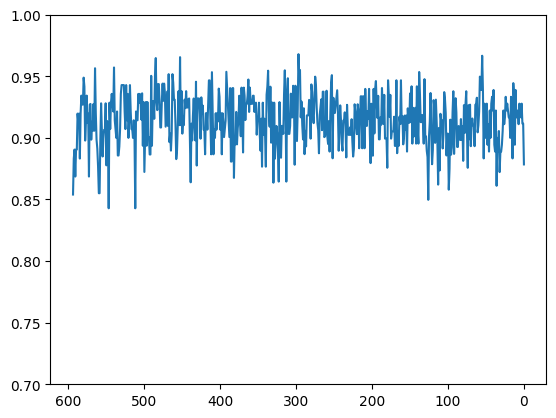

In [30]:
time_labels, time_labels_counts = zip(*time_labels_acc.items())
time_labels = [int(label) for label in time_labels]
plt.plot(time_labels, time_labels_counts)
plt.ylim([0.7,1])
plt.gca().invert_xaxis()
# plt.savefig(f"../plots/interictal_accuracy_timestep_{LOOKBACK}.pdf",dpi=400)

In [ ]:
correct_dict_save_path = f"../explainability_results/time_labels/{LOOKBACK}/time_labels_correct_counter_dict_sorted_normalized.json"
total_dict_save_path = f"../explainability_results/time_labels/{LOOKBACK}/time_labels_counter_dict.json"
if not os.path.exists(os.path.dirname(correct_dict_save_path)):
    os.makedirs(os.path.dirname(correct_dict_save_path))

with open(correct_dict_save_path, "w") as f:
    json.dump(sorted_dict, f)
with open(total_dict_save_path, "w") as f:
    json.dump(time_labels_counter_dict, f)